In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train1 = pd.read_csv("osdg_train_data_0424.csv", sep='\t', engine="python")
train2 = pd.read_csv("synt_sample.csv", engine="python")


In [3]:
# Selecting sentences with expert agreement abover 0.5
train1 = train1[train1["agreement"]>0.5]

In [4]:
# Creating a sample with 3000 sentences per category, keeping the same distribution as the original dataset
train2 = train2.groupby('category', group_keys=False).apply(
        lambda x: x.sample(frac=3500/len(train2))).reset_index(drop=True)


/var/folders/dm/4x9yw1317l3320_zc7brjgh00000gn/T/ipykernel_13585/4188799172.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train2 = train2.groupby('category', group_keys=False).apply(


In [5]:
# Ensure no duplicates between train1 and train2
existing_text_ids = set(train1['text_id'])

# Generate unique text_ids for train2
unique_text_ids = set()
while len(unique_text_ids) < len(train2):
    new_ids = np.random.choice(train1['text_id'], size=len(train2) - len(unique_text_ids), replace=False)
    unique_text_ids.update(new_ids)

# Assign the unique text_ids to train2
train2_text_ids = list(unique_text_ids)[:len(train2)]
train2 = train2.reset_index(drop=True)
train2['text_id'] = train2_text_ids

print(train2)


         id                                           sentence  \
0      9679  Nike released a new collection inspired by vin...   
1      4049  oversized blazers is making a comeback this se...   
2     11962  Gucci released a new collection inspired by vi...   
3      2505  oversized blazers is making a comeback this se...   
4       917  Wearing leather jacket is a timeless fashion c...   
...     ...                                                ...   
3496  16002  Paris is a must-visit destination for food lov...   
3497  14799  Many travelers prefer boat for scenic road trips.   
3498  13718  Tourists are drawn to Great Wall of China for ...   
3499  11836  Many travelers prefer boat for scenic road trips.   
3500   5561  Tourists are drawn to Great Wall of China for ...   

                 category                           text_id  
0     Fashion & Lifestyle  2c3a0cf5a380e1ca9413faf23eb39224  
1     Fashion & Lifestyle  9cbe0d3ae09e350e6741590edc85db1d  
2     Fashion & Lifes

In [6]:
# Rename sentence as text
train2.rename(columns={'sentence': 'text'}, inplace=True)

In [7]:
# Creating new column with sdg 0 value
train2["sdg"] = 0

In [8]:
# Concatenating the datasets
train = pd.concat([train1[["text_id", "text", "sdg"]], train2[["text_id", "text", "sdg"]]], ignore_index=True)

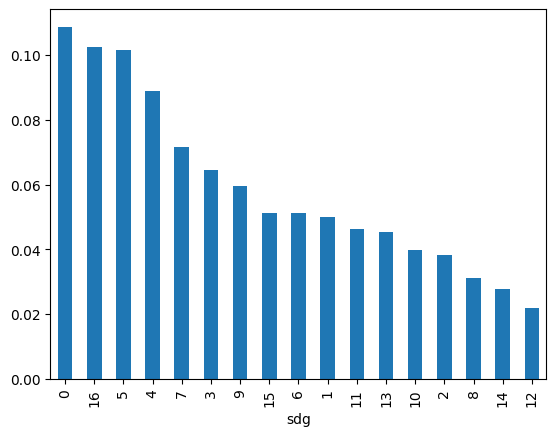

In [9]:
# Making sure the proportion of sdg 0 is not too high
train["sdg"].value_counts(normalize=True).plot(kind='bar')

# Shuffle the data to avoid order bias
train = train.sample(frac=1, random_state=139390).reset_index(drop=True)


In [10]:
# Spliting data between train, validation and test

from sklearn.model_selection import train_test_split

# Split into train (80%), temp (20%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    train["text"], train["sdg"], 
    test_size=0.2, 
    stratify=train["sdg"],  # Preserve class balance
    random_state=139390
)

# Split temp into val (10%) and test (10%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=42
)

In [11]:
# Using the same tokenizer as the model

from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("sadickam/sdgBERT")

# Tokenize a batch of texts
def tokenize(batch_texts):
    return tokenizer(
        batch_texts,
        padding="max_length",    # Pad to max_length
        truncation=True,         # Truncate to max_length
        max_length=512,          # Match the original model's max length
        return_tensors="pt",     # Return PyTorch tensors
    )

# Example tokenization for training texts
tokenized_train = tokenize(train_texts.tolist())

In [12]:
#Create the pytorch dataset

from torch.utils.data import Dataset, DataLoader
import torch

class SDGDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.encodings = tokenize(texts.tolist())  # Tokenize all texts upfront

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

# Create datasets
train_dataset = SDGDataset(train_texts, train_labels)
val_dataset = SDGDataset(val_texts, val_labels)
test_dataset = SDGDataset(test_texts, test_labels)

In [13]:
batch_size = 16  # Adjust based on GPU memory

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,    # Shuffle for training
    num_workers=4    # Parallelize data loading
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,   # No need to shuffle validation
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "sadickam/sdgBERT",
    num_labels=17,  # 16 SDGs + residual
    ignore_mismatched_sizes=True  # Required to resize the classifier layer
)

# Verify model architecture
print(model.classifier)  # Should show `out_features=17`

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sadickam/sdgBERT and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([16]) in the checkpoint and torch.Size([17]) in the model instantiated
- classifier.weight: found shape torch.Size([16, 768]) in the checkpoint and torch.Size([17, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=17, bias=True)


In [15]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)
model = model.to(device)

In [16]:
#pip install tf-keras
#%pip install 'accelerate>=0.26.0'


In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",          # Directory to save checkpoints
    learning_rate=3e-5,              # Slightly higher learning rate for faster convergence
    per_device_train_batch_size=16,  # Reduce batch size to fit memory
    per_device_eval_batch_size=16,   # Reduce batch size to fit memory
    num_train_epochs=3,              # Reduce number of epochs
    weight_decay=0.01,               # Regularization
    evaluation_strategy="steps",     # Evaluate every few steps instead of every epoch
    save_strategy="steps",           # Save a checkpoint every few steps
    logging_dir="./logs",            # TensorBoard logs
    load_best_model_at_end=True,     # Keep the best model
    metric_for_best_model="eval_loss",
    save_steps=1000,                 # Save checkpoint every 1000 steps
    eval_steps=1000,                 # Evaluate every 1000 steps
    logging_steps=100,               # Log every 100 steps
)

/Users/mass/.pyenv/versions/3.10.11/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Extract labels
        labels = inputs.pop("labels")
        
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Compute loss with class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, 17), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss
    

# Initialize Trainer with fixed compute_loss
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
import os

# Train the model
trainer.train()

# Save the final model
trainer.save_model("sdgBERT_with_residual_final")

Step,Training Loss,Validation Loss
